## Entity -> Wikipedia Current Events Pages

In [57]:
import requests
import calendar
from bs4 import BeautifulSoup


MONTH_NAMES = list(calendar.month_name)[1:]


def is_valid_monthly_wcep_url(url):
    '''
    good example: https://en.wikipedia.org/wiki/Portal:Current_events/October_2003
    bad examples:
    https://en.wikipedia.org/wiki/Portal:Current_events/2005_December_29
    https://en.wikipedia.org/wiki/Portal:Current_events/Middle_East/August_2006_in_the_Middle_East
    '''
    tail = url.split('Portal:Current_events')[-1]
    if len(tail.split('/')) != 2:
        return False
    parts = url.split('/')[-1].split('_')
    if len(parts) != 2:
        return False
    month, year = parts
    return month in MONTH_NAMES and year.isnumeric()


def get_wcep_links_linking_here(wikipedia_id):
    page = wikipedia_id.replace('_', '+')
    url = f'https://en.wikipedia.org/wiki/Special:WhatLinksHere?target={page}&namespace=100&limit=100000'
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')
    ul_element = soup.find('ul', id='mw-whatlinkshere-list')
    links = [li.a['href'] for li in ul_element.find_all('li') if li.a]
    base_url = 'https://en.wikipedia.org'
    absolute_links = [base_url + link if link.startswith('/') else link for link in links]
    monthly_wcep_links = [link for link in absolute_links if is_valid_monthly_wcep_url(link)]
    return monthly_wcep_links

In [58]:
wcep_links = get_wcep_links_linking_here('Gaza_Strip')
len(wcep_links)

179

In [59]:
wcep_links[:10]

['https://en.wikipedia.org/wiki/Portal:Current_events/October_2003',
 'https://en.wikipedia.org/wiki/Portal:Current_events/May_2002',
 'https://en.wikipedia.org/wiki/Portal:Current_events/August_2002',
 'https://en.wikipedia.org/wiki/Portal:Current_events/March_2002',
 'https://en.wikipedia.org/wiki/Portal:Current_events/October_2002',
 'https://en.wikipedia.org/wiki/Portal:Current_events/December_2002',
 'https://en.wikipedia.org/wiki/Portal:Current_events/April_2003',
 'https://en.wikipedia.org/wiki/Portal:Current_events/June_2003',
 'https://en.wikipedia.org/wiki/Portal:Current_events/August_2003',
 'https://en.wikipedia.org/wiki/Portal:Current_events/December_2003']

In [60]:
wcep_links[-1]

'https://en.wikipedia.org/wiki/Portal:Current_events/October_2023'

## Parse Monthly WCEP Pages

In [26]:
import datetime
import calendar
import collections
import arrow
from dataclasses import dataclass, field, asdict
from bs4 import BeautifulSoup


def month_to_int():
    month_to_int = {}
    for i, month in enumerate(calendar.month_name):
        if i > 0:
            month_to_int[month] = i
    return month_to_int


MONTH_TO_INT = month_to_int()


@dataclass
class EventBullet:
    text: str = None
    id: str = None
    date: datetime.datetime = None
    category: str = None
    topics: list = field(default_factory=list)
    wiki_links: list = field(default_factory=list)
    references: list = field(default_factory=list)


def url_to_time(url, month_to_num):
    tail = url.split('/')[-1]
    month, year = tail.split('_')
    m = month_to_num[month]
    y = int(year)
    return datetime.datetime(year=y, month=m, day=1)


def extract_date(date_div):
    date = date_div.find('span', class_='summary')
    date = date.text.split('(')[1].split(')')[0]
    date = arrow.get(date)
    date = datetime.date(date.year, date.month, date.day)
    return date


def wiki_link_to_id(s):
    return s.split('/wiki/')[1]


def extract_event_bullets(e, date, category):
    events = []
    topic_to_child = collections.defaultdict(set)
    topic_to_parent = collections.defaultdict(set)

    def recursively_extract_event_bullets(e,
                                    date,
                                    category,
                                    prev_topics,
                                    is_root=False):
        if is_root:
            lis = e.find_all('li', recursive=False)
            result = [recursively_extract_event_bullets(li, date, category, [])
                    for li in lis]
            return result
        else:
            ul = e.find('ul')
            if ul:
                # intermediate "node", e.g. a topic an event is assigned to

                links = e.find_all('a', recursive=False)
                new_topics = []
                for link in links:
                    try:
                        new_topics.append(wiki_link_to_id(link.get('href')))
                    except:
                        print("not a wiki link:", link)
                lis = ul.find_all('li', recursive=False)

                for prev_topic in prev_topics:
                    for new_topic in new_topics:
                        topic_to_child[prev_topic].add(new_topic)
                        topic_to_parent[new_topic].add(prev_topic)

                topics = prev_topics + new_topics
                for li in lis:
                    recursively_extract_event_bullets(li, date, category, topics)

            else:
                # reached the "leaf", i.e. event summary
                text = e.text
                wiki_links = []
                references = []
                for link in e.find_all('a'):
                    url = link.get('href')
                    if link.get('rel') == ['nofollow']:
                        references.append(url)
                    elif url.startswith('/wiki'):
                        wiki_links.append(url)
                event = EventBullet(
                    text=text,
                    date=date,
                    category=category,
                    topics=prev_topics,
                    wiki_links=wiki_links,
                    references=references
                )
                events.append(event)

    recursively_extract_event_bullets(e, date, category, [], is_root=True)
    return events


def process_month_page_2004_to_2017(html):
    soup = BeautifulSoup(html, 'html.parser')
    days = soup.find_all('table', class_='vevent')
    events = []
    for day in days:
        date = extract_date(day)
        category = None
        desc = day.find('td', class_='description')
        for e in desc.children:
            if e.name == 'dl':
                category = e.text
            elif e.name == 'ul':
                events += extract_event_bullets(e, date, category)
    return events


def process_month_page_from_2018(html):
    soup = BeautifulSoup(html, 'html.parser')
    days = soup.find_all('div', class_='vevent')
    events = []
    for day in days:
        date = extract_date(day)
        #print('DATE:', date)
        category = None
        desc = day.find('div', class_='description')
        for e in desc.children:
            if e.name == 'div' and e.get('role') == 'heading':
                category = e.text
                #print('-'*25, 'CATEGORY:', category, '-'*25, '\n')
            elif e.name == 'ul':
                events += extract_event_bullets(e, date, category)
    return events

In [18]:
wcep_url = 'https://en.wikipedia.org/wiki/Portal:Current_events/2023_October_25'
events = process_month_page_from_2018(requests.get(wcep_url).text)

In [24]:
asdict(events[0])

{'text': 'The Gaza Health Ministry says that at least 704 people have died in the past day. The UN relief agency says this was "the highest fatality toll reported in a single day". (The Hill) (Al Jazeera)',
 'id': None,
 'date': datetime.date(2023, 10, 25),
 'category': None,
 'stories': ['Gaza%E2%80%93Israel_conflict', '2023_Israel%E2%80%93Hamas_war'],
 'wiki_links': ['/wiki/Gaza_Health_Ministry', '/wiki/UNRWA'],
 'references': ['https://thehill.com/policy/international/4272805-704-dead-airstrikes-gaza-israel-hamas/',
  'https://www.aljazeera.com/news/liveblog/2023/10/23/israel-hamas-war-live-hundreds-killed-israeli-strikes-gaza']}

## Combined: Entity -> CEP Events

In [151]:
import tqdm
import urllib.parse
# import asyncio
# import httpx


# async def process_monthly_wcep_urls(wcep_url):
#     async with httpx.AsyncClient() as client:
#         response = await client.get(wcep_url)
#         html = response.text
#         year = int(wcep_url.split('_')[-1])
#         if 2004 <= year < 2018:
#             events = process_month_page_2004_to_2017(html)
#         elif 2018 <= year :
#             events = process_month_page_from_2018(html)
#         return events


# async def entity_to_events(wikipedia_id):
#     wcep_links = get_wcep_links_linking_here(wikipedia_id)
#     return await asyncio.gather(*[process_monthly_wcep_urls(url) for url in wcep_links])


def entity_to_events(wikipedia_id):
    wcep_links = get_wcep_links_linking_here(wikipedia_id)
    events = []
    for url in tqdm.tqdm(wcep_links):
        response = requests.get(url)
        html = response.text
        year = int(url.split('_')[-1])
        if 2004 <= year < 2018:
            events += process_month_page_2004_to_2017(html)
        elif 2018 <= year :
            events += process_month_page_from_2018(html)
    events.sort(key=lambda x: x.date)
    # we only keep events with link to our entity of interest
    events = [
        e for e in events
        if any([
            urllib.parse.unquote(wiki_link).endswith(wikipedia_id)
            for wiki_link in e.wiki_links
        ])
    ]
    return events

In [152]:
events = entity_to_events("Recep_Tayyip_Erdoğan")
len(events)

 61%|██████    | 59/97 [00:39<00:24,  1.56it/s]

not a wiki link: <a class="new" href="/w/index.php?title=Colonization_of_Europa&amp;action=edit&amp;redlink=1" title="Colonization of Europa (page does not exist)">Colonization of Europa</a>


 66%|██████▌   | 64/97 [00:42<00:21,  1.55it/s]

not a wiki link: <a class="external text" href="https://www.npr.org/2019/10/02/766404561/wto-says-u-s-can-hit-eu-with-7-5-billion-in-tariffs-over-airbus-subsidies" rel="nofollow">(NPR)</a>
not a wiki link: <a class="new" href="/w/index.php?title=Manchester_Arndale_stabbing&amp;action=edit&amp;redlink=1" title="Manchester Arndale stabbing (page does not exist)">Manchester Arndale stabbing</a>


 69%|██████▉   | 67/97 [00:44<00:19,  1.51it/s]

not a wiki link: <a class="external text" href="https://www.si.com/wrestling/2020/06/19/hashtag-speaking-out-wrestling-industry-abusive-behavior" rel="nofollow">(<i>Sports Illustrated</i>)</a>
not a wiki link: <a class="external text" href="https://www.boston.com/sports/boston-red-sox/2020/06/25/eddie-kasko-red-sox-obituary/amp" rel="nofollow">(Boston)</a>


 70%|███████   | 68/97 [00:45<00:20,  1.42it/s]

not a wiki link: <a class="new" href="/w/index.php?title=Sheikhupura_train-van_crash&amp;action=edit&amp;redlink=1" title="Sheikhupura train-van crash (page does not exist)">Sheikhupura train-van crash</a>


 71%|███████   | 69/97 [00:46<00:21,  1.32it/s]

not a wiki link: <a class="new" href="/w/index.php?title=2020_Chaman_bombing&amp;action=edit&amp;redlink=1" title="2020 Chaman bombing (page does not exist)">2020 Chaman bombing</a>
not a wiki link: <a class="new" href="/w/index.php?title=Draft:Osaka_Nana_Grave&amp;action=edit&amp;redlink=1" title="Draft:Osaka Nana Grave (page does not exist)">Osaka Nana Grave</a>


 72%|███████▏  | 70/97 [00:47<00:21,  1.23it/s]

not a wiki link: <a class="new" href="/w/index.php?title=2020_Lyon_shooting&amp;action=edit&amp;redlink=1" title="2020 Lyon shooting (page does not exist)">2020 Lyon shooting</a>


 79%|███████▉  | 77/97 [00:53<00:17,  1.12it/s]

not a wiki link: <a class="external text" href="https://news.sky.com/story/nazanin-zaghari-ratcliffe-uk-to-pay-tehran-163400m-to-free-british-iranian-national-state-tv-reports-12293267" rel="nofollow">(Sky News)</a>


 80%|████████  | 78/97 [00:54<00:16,  1.15it/s]

not a wiki link: <a class="new" href="/w/index.php?title=House_Resolution_3005&amp;action=edit&amp;redlink=1" title="House Resolution 3005 (page does not exist)">House Resolution 3005</a>


 82%|████████▏ | 80/97 [00:56<00:14,  1.17it/s]

not a wiki link: <a class="new" href="/w/index.php?title=2021_Damascus_bus_bombing&amp;action=edit&amp;redlink=1" title="2021 Damascus bus bombing (page does not exist)">2021 Damascus bus bombing</a>


 85%|████████▍ | 82/97 [00:58<00:12,  1.23it/s]

not a wiki link: <a class="new" href="/w/index.php?title=14-Year-Old_Valentina_Orellana-Peralta_killed_in_LAPD_response&amp;action=edit&amp;redlink=1" title="14-Year-Old Valentina Orellana-Peralta killed in LAPD response (page does not exist)">14-Year-Old Valentina Orellana-Peralta killed in LAPD response</a>


 87%|████████▋ | 84/97 [00:59<00:11,  1.17it/s]

not a wiki link: <a class="new" href="/w/index.php?title=Battle_of_Zaporizhzhia&amp;action=edit&amp;redlink=1" title="Battle of Zaporizhzhia (page does not exist)">Battle of Zaporizhzhia</a>


 90%|████████▉ | 87/97 [01:01<00:07,  1.34it/s]

not a wiki link: <a class="new" href="/w/index.php?title=2022_As-Suwayda_clashes&amp;action=edit&amp;redlink=1" title="2022 As-Suwayda clashes (page does not exist)">2022 As-Suwayda clashes</a>


 93%|█████████▎| 90/97 [01:03<00:04,  1.48it/s]

not a wiki link: <a class="new" href="/w/index.php?title=Incarceration_of_Ana_Montes&amp;action=edit&amp;redlink=1" title="Incarceration of Ana Montes (page does not exist)">Incarceration of Ana Montes</a>
not a wiki link: <a class="new" href="/w/index.php?title=Rishi_Sunak_seatbelt_incident&amp;action=edit&amp;redlink=1" title="Rishi Sunak seatbelt incident (page does not exist)">Rishi Sunak seatbelt incident</a>


 95%|█████████▍| 92/97 [01:04<00:03,  1.64it/s]

not a wiki link: <a class="new" href="/w/index.php?title=2023_Nayarit_bus_crash&amp;action=edit&amp;redlink=1" title="2023 Nayarit bus crash (page does not exist)">2023 Nayarit bus crash</a>


 96%|█████████▌| 93/97 [01:06<00:03,  1.14it/s]

not a wiki link: <a class="new" href="/w/index.php?title=2023_Ratingen_explosion&amp;action=edit&amp;redlink=1" title="2023 Ratingen explosion (page does not exist)">2023 Ratingen explosion</a>


 98%|█████████▊| 95/97 [01:07<00:01,  1.25it/s]

not a wiki link: <a class="new" href="/w/index.php?title=2023_Italy_wildfires&amp;action=edit&amp;redlink=1" title="2023 Italy wildfires (page does not exist)">2023 Italy wildfires</a>
not a wiki link: <a class="new" href="/w/index.php?title=2023_Langweid_am_Lech_shooting&amp;action=edit&amp;redlink=1" title="2023 Langweid am Lech shooting (page does not exist)">2023 Langweid am Lech shooting</a>


 99%|█████████▉| 96/97 [01:08<00:00,  1.31it/s]

not a wiki link: <a class="new" href="/w/index.php?title=2023_National_Aerobatic_Team_Aermacchi_MB-339_crash&amp;action=edit&amp;redlink=1" title="2023 National Aerobatic Team Aermacchi MB-339 crash (page does not exist)">2023 National Aerobatic Team Aermacchi MB-339 crash</a>


100%|██████████| 97/97 [01:09<00:00,  1.40it/s]


91

In [150]:
import urllib.parse


wikipedia_id = 'Recep_Tayyip_Erdoğan'
interesting_events = []
for e in events:
    for wl in e.wiki_links:
        wl2 = urllib.parse.unquote(wl)
        if wl2.endswith(wikipedia_id):
            print(wl2)

/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/wiki/Recep_Tayyip_Erdoğan
/

In [154]:
dates = [e.date for e in events]
date_counter = collections.Counter(dates)
unique_dates = sorted(set(dates))
date_counts = [date_counter[d] for d in unique_dates]

In [156]:
list(zip(unique_dates, date_counts))

[(datetime.date(2018, 1, 5), 1),
 (datetime.date(2018, 1, 21), 1),
 (datetime.date(2018, 1, 26), 1),
 (datetime.date(2018, 2, 26), 1),
 (datetime.date(2018, 3, 20), 1),
 (datetime.date(2018, 3, 26), 1),
 (datetime.date(2018, 4, 5), 1),
 (datetime.date(2018, 4, 10), 1),
 (datetime.date(2018, 4, 22), 1),
 (datetime.date(2018, 4, 25), 1),
 (datetime.date(2018, 4, 30), 1),
 (datetime.date(2018, 6, 24), 1),
 (datetime.date(2018, 7, 8), 1),
 (datetime.date(2018, 8, 18), 1),
 (datetime.date(2018, 9, 26), 1),
 (datetime.date(2018, 10, 23), 1),
 (datetime.date(2018, 11, 11), 1),
 (datetime.date(2019, 3, 31), 1),
 (datetime.date(2019, 5, 6), 1),
 (datetime.date(2019, 9, 4), 1),
 (datetime.date(2019, 9, 5), 1),
 (datetime.date(2019, 9, 8), 1),
 (datetime.date(2019, 9, 27), 1),
 (datetime.date(2019, 10, 5), 1),
 (datetime.date(2019, 10, 6), 1),
 (datetime.date(2019, 10, 9), 1),
 (datetime.date(2019, 10, 10), 1),
 (datetime.date(2019, 10, 17), 1),
 (datetime.date(2019, 10, 22), 1),
 (datetime.date(

In [113]:
dates[0], dates[-1]

(datetime.date(2005, 1, 8), datetime.date(2023, 10, 26))

<Axes: xlabel='Date'>

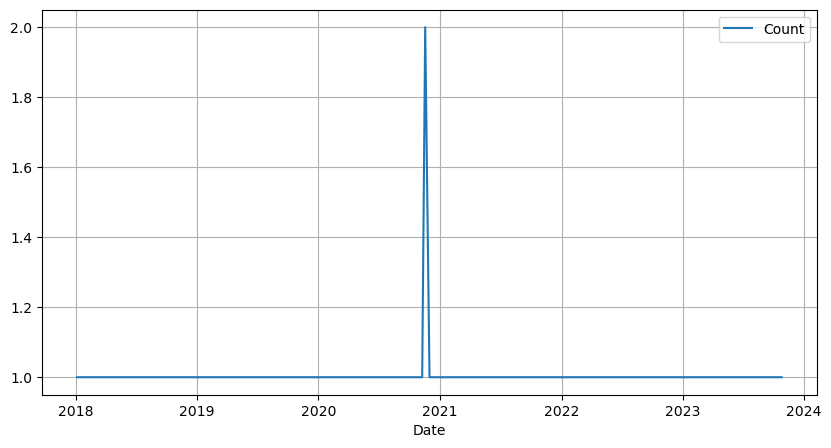

In [157]:
import pandas as pd

df = pd.DataFrame({'Date': unique_dates, 'Count': date_counts})
df.set_index('Date').plot(figsize=(10, 5), grid=True)

## Signal-like Time-ordered Dataset

In [158]:
import textwrap
for e in events:
    print(textwrap(e.date())
    print(e.text)
    print()

2018-01-05
Turkish President Recep Tayyip Erdoğan says he is "tired" of waiting for the European Union to approve Turkey's membership in the political union. (Al Jazeera)

2018-01-21
Turkish President Erdoğan announces that Turkish Army ground troops have entered the district of Afrin in Syria. Turkish Prime Minister Binali Yıldırım says the goal is to establish a 30-km safe zone. (Voice of America)

2018-01-26
President of Turkey Recep Tayyip Erdoğan says the Afrin offensive, as announced, is now to turn east, towards Manbij and the border with Iraq. (Reuters)

2018-02-26
French President Emmanuel Macron phones Turkish President Recep Tayyip Erdoğan, telling Erdoğan that the UN-approved ceasefire in Syria also applies in the Afrin Region. (Reuters)

2018-03-20
Turkish President Recep Tayyip Erdoğan asserts his nation will secure Northern Cyprus' access to natural hydrocarbon resources off the Cypriot coast. The comments come amid disputes as to sovereign rights and access to offshore 